In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
!python -m spacy download en_core_web_md 
!pip install pyLDAvis
import en_core_web_sm
import gensim
from gensim import corpora
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyLDAvis
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import MiniBatchKMeans,KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
root = "/content/drive/MyDrive/USML_Final_Project/topic-modeling-datasets-master/data/raw/20news-bydate/20news-bydate-train"

In [ ]:
def read_files(file_path):
   with open(file_path, 'r') as file:
      print(file.read())

In [ ]:
os.chdir(root)
os.listdir()

['alt.atheism',
 'rec.sport.baseball',
 'sci.med',
 'rec.motorcycles',
 'talk.religion.misc',
 'comp.sys.ibm.pc.hardware',
 'sci.space',
 'sci.electronics',
 'comp.graphics',
 'talk.politics.guns',
 'sci.crypt',
 'Countvect_LSA_wordcloud.jpg']

In [ ]:
list_needed = ['sci.crypt',
 'rec.sport.baseball',
 'sci.med',
 'rec.motorcycles',
 'talk.religion.misc',
 'comp.sys.ibm.pc.hardware',
 'sci.space',
 'rec.motorcycles',
 'comp.graphics',
 'talk.politics.guns']

In [ ]:
file_content = []
for direc in list_needed:
  for file in os.listdir(root+"/"+direc):
      file_path =f"{root}/{direc}/{file}"
      file_size = os.path.getsize(file_path)
      # fd = os.open(file_path,os.O_RDONLY)
      # content = os.read(fd,file_size).decode('ascii')
      fd = open(file_path,encoding="ISO-8859-1")
      content = fd.read(file_size)
      file_content.append(content)

In [ ]:
data = pd.DataFrame(file_content,columns=["Text_content"])
data.head()

,Text_content
0,From: trussell@cwis.unomaha.edu (Tim Russell)\...
1,From: Grant@DOCKMASTER.NCSC.MIL (Lynn R Grant)...
2,From: mcbeeb@atlantis.CSOS.ORST.EDU (Brian Mcb...
3,From: jhan@debra.dgbt.doc.ca (Jerry Han)\nSubj...
4,From: jebright@magnus.acs.ohio-state.edu (Jame...


In [ ]:
data.reset_index(inplace=True)
data.head()

,index,Text_content
0,0,From: trussell@cwis.unomaha.edu (Tim Russell)\...
1,1,From: Grant@DOCKMASTER.NCSC.MIL (Lynn R Grant)...
2,2,From: mcbeeb@atlantis.CSOS.ORST.EDU (Brian Mcb...
3,3,From: jhan@debra.dgbt.doc.ca (Jerry Han)\nSubj...
4,4,From: jebright@magnus.acs.ohio-state.edu (Jame...


In [ ]:
data.shape

(5672, 2)

# PREPROCESSING

In [ ]:
def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''

    #Remove emails
    messages_cleaned = re.sub(r'\S+@\S+','',message)

    #Remove Punctuation
    messages_cleaned = re.sub(r'[^\w\s]', '', messages_cleaned)
    
    #Remove Links
    messages_cleaned = re.sub(r'https?://\S+', '', messages_cleaned)

    #Removing alphanumeric
    messages_cleaned =re.sub( r'([a-zA-Z]*\d+[a-zA-Z]+|[a-zA-Z]+\d+[a-zA-Z]*)','',messages_cleaned) 

    #Removing number with text:
    messages_cleaned = re.sub(r'\d+', '', messages_cleaned)

    #Removing stand alone numbers:
    messages_cleaned = re.sub(r'[0-9]', '', messages_cleaned)

    #Lower Case
    messages_cleaned = messages_cleaned.lower()
    
    #Tokenize
    messages_cleaned = word_tokenize(messages_cleaned)
    
    #Remove Stopwords
    stop_words_list = stopwords.words('english')
    for token in messages_cleaned:
        if token in stop_words_list:
            messages_cleaned.remove(token)
    # cl=""
    # for i in messages_cleaned:
    #   cl=cl+" "+i
    return ' '.join(messages_cleaned)

In [ ]:
clean_data = data.copy(deep=True)

In [ ]:
clean_data['Text_content'] = clean_data['Text_content'].apply(clean_message)

In [ ]:
clean_data.head()

,index,Text_content
0,0,tim russell subject once tapped code good orga...
1,1,lynn r grant subject another key registration ...
2,2,brian mcbee subject can clipper stay classifie...
3,3,jerry han subject overreacting re tapped code ...
4,4,james r ebright subject shelf cheap des keysea...


In [ ]:
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [ ]:
text_list=clean_data['Text_content'].tolist()
print(text_list[1])
clean_data['Text_content'] = lemmatization(text_list)

lynn r grant subject another key registration body bites dust imho organization yale cs mailnews gateway lines one candidates has suggested key registration body aclu think poor choice aclu essentially group auditors audit peoples civil liberties administered traditionally auditors like get involved design operational aspects things with good reason systems programmer always infuriated auditors would come tell us implementation stunk security point view wouldnt tell us fix i always figured just liked critcize without work help fix problem i took stint an auditor i found real reason auditors dont like recommend solutions puts bad position criticize implementation later auditee say well told us way would ok compromises independence a necessary part auditors job taking case hand suppose aclu becomes a key half registrar suppose perhaps some error aclus part a key half gets away shouldnt used deprive someone her civil liberties aclu gets wind wants take court end being time the side the de

In [ ]:
clean_data.head()

,index,Text_content
0,0,"[distribution, line, quick, people, administra..."
1,1,"[grant, key, registration, body, line, candida..."
2,2,"[clipper, articleid, distribution, line, atlan..."
3,3,"[re, code, nntppostinghost, debradgbtdocca, di..."
4,4,"[subject, shelf, cheap, machine, corporate, ac..."


## LSA

### Counter vectorizer + SVD

In [ ]:
clean_data['Text_content']

0       [distribution, line, quick, people, administra...
1       [grant, key, registration, body, line, candida...
2       [clipper, articleid, distribution, line, atlan...
3       [re, code, nntppostinghost, debradgbtdocca, di...
4       [subject, shelf, cheap, machine, corporate, ac...
                              ...                        
5667    [mane, gun, control, distribution, version, li...
5668    [line, article, article, ticket, veep, duke, t...
5669    [line, distribution, article, harmful, gassing...
5670    [subject, friend, period, background, check, p...
5671    [thank, nntppostinghost, line, good, job, arti...
Name: Text_content, Length: 5672, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

list_text = text_list=clean_data['Text_content'].tolist()
list_text = [' '.join(i) for i in list_text]
vect = CountVectorizer(stop_words='english')
vector_form = vect.fit_transform(list_text)
vector_form.todense().shape

(5672, 23107)

In [ ]:
dictionary = vect.get_feature_names()
len(dictionary)

23107

In [ ]:
vector_form.shape

(5672, 23107)

In [ ]:
from sklearn.decomposition import TruncatedSVD
#Perform SVD
def run_svd(vector_form,n_comp,start=1, stop=1000, step=50 ,n_iter=100,range_ = False):
  variance_ratio_list = []
  singular_values = []
  if range_ :
    for comp in range(start,stop,step):
      print("Number of components = {}".format(comp))
      svd = TruncatedSVD(n_components=comp)
      fit = svd.fit_transform(vector_form)
      variance_ratio_list.append(svd.explained_variance_ratio_.sum())
      singular_values.append(svd.singular_values_)
      print("Completed!!")
    return variance_ratio_list,singular_values
  else:
    U, sigma, VT = randomized_svd(vector_form, 
                              n_components=n_comp,
                              n_iter=n_iter,
                              random_state=122)
    svd = TruncatedSVD(n_components=n_comp,algorithm='randomized', n_iter=n_iter, random_state=122) # Taking 18 components because it explains almost 80% variance
    fit = svd.fit_transform(vector_form)
    return U,sigma,VT,svd.components_,svd

In [ ]:
#Plot the variance curve
def plot_variance_graph(vector_form,start=1, stop=1000, step=50,thresh = 0.8,range_value= False):
    x = range(start,stop,step)
    print("Calculating total variance for n_components in the range {} - {} with step size = {} .....".format(start,stop,step))
    variance_ratio_list,singular_values = run_svd(start = start,
                                                    stop = stop,
                                                    step = step,
                                                    vector_form = vector_form,
                                                    range_ = True if range_value else False)
    print("Done!!!")
    print("Plotting the graph....")
    plt.plot(x, variance_ratio_list)
    plt.xlabel("Number of components")
    plt.ylabel("Total Variance explained")
    plt.axhline(y=thresh, color='r', linestyle='-')
    # plt.legend(("total"), loc='best')
    plt.show()
    return variance_ratio_list,singular_values

Calculating total variance for n_components in the range 1 - 1000 with step size = 50 .....
Number of components = 1
Completed!!
Number of components = 51
Completed!!
Number of components = 101
Completed!!
Number of components = 151
Completed!!
Number of components = 201
Completed!!
Number of components = 251
Completed!!
Number of components = 301
Completed!!
Number of components = 351
Completed!!
Number of components = 401
Completed!!
Number of components = 451
Completed!!
Number of components = 501
Completed!!
Number of components = 551
Completed!!
Number of components = 601
Completed!!
Number of components = 651
Completed!!
Number of components = 701
Completed!!
Number of components = 751
Completed!!
Number of components = 801
Completed!!
Number of components = 851
Completed!!
Number of components = 901
Completed!!
Number of components = 951
Completed!!
Done!!!
Plotting the graph....


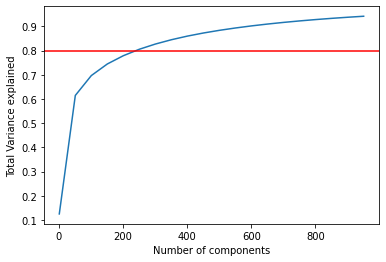

In [ ]:
#Calculating variance
variance_ratio_list,singular_values_list = plot_variance_graph(start=1,
                                                               stop=1000, step=50,
                                                               vector_form=vector_form,
                                                               range_value = True)

In [ ]:
print(len([[i for i in j if i>100.0] for j in singular_values_list][1]))

18


In [ ]:
print(len([[i for i in j if i>150.0] for j in singular_values_list][1]))

7


### From the above graph we can see that the optimal n_components value in somewhere between 200 and 400. Let's try on some values within the range

In [ ]:

def assign_topics(clean_data,U):
  topics = ["topic"+str(i) for i in range(1,U.shape[1]+1)]
  data = pd.DataFrame(U.T,index=topics) 
  return data

In [ ]:
U,sigma,VT,comp,model7 = run_svd(vector_form = vector_form,
                          n_comp = 7,
                          range_ = False)

In [ ]:
def get_topics(vect,components): 
  vocab = vect.get_feature_names()
  topic_word_list = []
  for i, comp in enumerate(components):
    terms_comp = zip(vocab,comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    topic=" "
    # print(sorted_terms)
    for t in sorted_terms:
      topic = topic + ' ' + t[0]
    # print(topic)
    topic_word_list.append(topic)
  return topic_word_list

In [ ]:
tp_word_list7 = get_topics(vect,comp)
tp_word_list7

['  file image program available information user internet',
 '  image jpeg file format color version quality',
 '  file gun firearm control law weapon crime',
 '  drive disk hard controller gun file bio',
 '  launch space year satellite key time technology',
 '  launch space satellite service year anonymous market',
 '  launch satellite space file commercial technology market']

In [ ]:
U,sigma,VT,comp,model18 = run_svd(vector_form = vector_form,
                          n_comp = 18,
                          range_ = False)

In [ ]:
tp_word_list18 = get_topics(vect,comp)
tp_word_list18

['  file image program available information user internet',
 '  image jpeg file format color version quality',
 '  file gun firearm control law weapon crime',
 '  drive disk hard controller gun file bio',
 '  launch space year satellite key time technology',
 '  launch space satellite service year anonymous market',
 '  launch satellite space file commercial technology market',
 '  jpeg people anonymous posting good quality gif',
 '  child use image law technology privacy year',
 '  image gun people right government tool weapon']

In [ ]:
U,sigma,VT,comp,model10 = run_svd(vector_form = vector_form,
                          n_comp = 10,
                          range_ = False)
tp_word_list10 = get_topics(vect,comp)
tp_word_list10

['  file image program available information user internet',
 '  image jpeg file format color version quality',
 '  file gun firearm control law weapon crime',
 '  drive disk hard controller gun file bio',
 '  launch space year satellite key time technology',
 '  launch space satellite service year anonymous market',
 '  launch satellite space file commercial technology market',
 '  jpeg people anonymous posting good quality gif',
 '  child use image law technology privacy year',
 '  image gun people right government tool weapon']

In [ ]:
def draw_word_cloud(topic_word_list,file_name,r=None):
  topic_size = len(topic_word_list)
  print(topic_size)
  if not r:
    r = int(topic_size/4)
  fig, ax = plt.subplots(r+1,4,figsize=(25,25))
  # plt.subplots_adjust(wspace=None, hspace=None)
  fig.subplots_adjust(wspace=None,hspace=None)
  print("R values: ",r)
  if topic_size<4:
    for i in range(topic_size):
      wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[i])
      # wc.recolor(color_func = black_color_func)
      ax.imshow(wc, interpolation="bilinear")
      ax.title(f"Topic{i+1}")
      ax.axis("off")
      ax.show()
  # for i in range(topic_size):
  #   wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[i])
  #   # wc.recolor(color_func = black_color_func)
  #   'ax'+str(i+1).imshow(wc, interpolation="bilinear")
  #   'ax'+str(i+1).title(f"Topic{i+1}")
  #   'ax'+str(i+1).axis("off")
  #   'ax'+str(i+1).show()
  else:
    for i in range(1,r+2):
      for j in range(1,5):
        if (i-1)*4+j <= topic_size:
          wc = WordCloud(width=1000, height=600, margin=3,  prefer_horizontal=0.7,scale=1,background_color='black', relative_scaling=0).generate(topic_word_list[(i-1)*4+j-1])
          ax[i-1,j-1].imshow(wc)
          ax[i-1,j-1].set_title(f"Topic {(i-1)*4+j}")
          ax[i-1,j-1].axis("off")
          # ax[i, j].subplots_adjust(wspace=None,hspace=None)
        else:
          fig.delaxes(ax[i-1,j-1])
  os.chdir("/content/")
  fig.tight_layout()
  fig.savefig(file_name+'.jpg')

In [ ]:
draw_word_cloud(tp_word_list18,"Countvect_LSA_wordcloud_18")

In [ ]:
draw_word_cloud(tp_word_list7,"Countvect_LSA_wordcloud_7")

In [ ]:
draw_word_cloud(tp_word_list10,"Countvect_LSA_wordcloud_10")

In [ ]:
n_comp = 250

In [ ]:
vocab = np.array(vect.get_feature_names())

In [ ]:
for i in (sorted(vocab.items(), key=lambda x:x[1])):
  if i[0].isalnum():
    print(i)

In [ ]:
num_top_words = 10

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
model10.components_

array([[ 1.26083726e-05,  1.43546619e-04,  5.61225862e-05, ...,
         1.81174554e-06,  2.77386092e-06,  1.75751813e-06],
       [-2.09871328e-05, -1.56558216e-04, -5.28481687e-05, ...,
        -1.23652734e-06, -3.77337976e-06, -9.13204874e-07],
       [ 7.12170897e-06, -1.32468212e-04, -7.31486353e-05, ...,
        -2.19887548e-06, -4.19895387e-06, -8.05550344e-07],
       ...,
       [ 5.13741922e-05,  7.91141752e-04, -3.68992308e-04, ...,
         8.94308764e-06,  1.29404531e-05, -6.05623689e-06],
       [ 2.16444803e-06, -3.73788434e-04, -2.13185385e-05, ...,
        -1.81700814e-05, -7.86396686e-06, -9.43384565e-06],
       [ 7.25081019e-05, -3.96856755e-04, -3.01875483e-05, ...,
         1.99637546e-06, -3.67893132e-06, -7.73136553e-06]])

In [ ]:
VT[:10].shape

(7, 23107)

In [ ]:
# print(svd.components_.shape) # (no_of_topics*no_of_words)
# # print(svd.components_)
# print(svd.singular_values_.shape)
# print(svd.feature_names_in_())

Using Gensim Library

In [ ]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(clean_data['Text_content'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_data['Text_content']]

In [ ]:
len(np.array(doc_term_matrix))

5672

In [ ]:
len(dictionary)

23276

In [ ]:
lsamodel = LsiModel(doc_term_matrix, id2word = dictionary)  # train model
# print(lsamodel.print_topics(num_words=words))

In [ ]:
lsamodel.get_topics().shape

(200, 23276)

In [ ]:
len(doc_term_matrix)

5672

In [ ]:
def calc_coherence(dictionary,texts,doc_term_matrix,num_topics_list):
  coh_value_dict = {}
  for num_topics in num_topics_list:
    lsamodel = LsiModel(doc_term_matrix,num_topics=num_topics, id2word = dictionary)
    coherencemodel = CoherenceModel(model=lsamodel, texts=texts, dictionary=dictionary , coherence='c_v') 
    coh_value_dict[lsamodel] = coherencemodel.get_coherence()
  
  return coh_value_dict

In [ ]:
clean_docs = clean_data['Text_content'].tolist()

In [ ]:
#Number of topics
num_topics_list = [2,4,6,8,10,14,18,20,25,30]

In [ ]:
coh_value_dict = calc_coherence(dictionary,clean_docs,doc_term_matrix,num_topics_list)

In [ ]:
coh_value_dict

{<gensim.models.lsimodel.LsiModel at 0x7f038fc15890>: 0.5310456442986323,
 <gensim.models.lsimodel.LsiModel at 0x7f038fb805d0>: 0.4491992160384664,
 <gensim.models.lsimodel.LsiModel at 0x7f0440dd2f50>: 0.4027421165754269,
 <gensim.models.lsimodel.LsiModel at 0x7f04405fd610>: 0.6778752904473255,
 <gensim.models.lsimodel.LsiModel at 0x7f0399aa1e10>: 0.40100603713562527,
 <gensim.models.lsimodel.LsiModel at 0x7f0398a83ed0>: 0.34780266736068866,
 <gensim.models.lsimodel.LsiModel at 0x7f0399b20a90>: 0.3653766580147611,
 <gensim.models.lsimodel.LsiModel at 0x7f03901f2ed0>: 0.6680743181179797,
 <gensim.models.lsimodel.LsiModel at 0x7f04408da610>: 0.6653618261190752,
 <gensim.models.lsimodel.LsiModel at 0x7f0390067650>: 0.4964011196198129}

In [ ]:
#Fucntion for plotting coherence plot
def plot_coherence_graph(num_topics_list,coh_values):
  x = num_topics_list
  plt.plot(x, coh_values)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()
  return dict(zip(num_topics_list,coh_values))

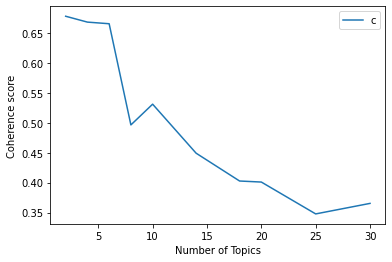

In [ ]:
coh_value_zip = plot_coherence_graph(num_topics_list,list(coh_value_dict.values()))

In [ ]:
coh_value_zip

{2: 0.4322877426660516,
 4: 0.5705804989543432,
 6: 0.3734875501247334,
 8: 0.42857714989708356,
 10: 0.39701640732232246,
 14: 0.35020316765878795,
 18: 0.3990298938596078,
 20: 0.38122285222812696,
 25: 0.3644434913470846,
 30: 0.35835160402008975}

In [ ]:
max_coh_num_topics = max(coh_value_zip, key=coh_value_zip.get)
max_coh_num_model = max(coh_value_dict, key=coh_value_dict.get)

In [ ]:
#Printing Topic and terms
for i in max_coh_num_model.print_topics(num_topics=max_coh_num_topics, num_words=10):
  print("Topic :", i)

Topic : (0, '0.431*"image" + 0.426*"file" + 0.163*"system" + 0.158*"program" + 0.148*"jpeg" + 0.142*"available" + 0.137*"format" + 0.129*"version" + 0.121*"other" + 0.114*"software"')
Topic : (1, '-0.384*"wire" + 0.307*"file" + 0.291*"image" + -0.222*"wiring" + -0.193*"outlet" + -0.190*"circuit" + -0.155*"ground" + -0.139*"neutral" + -0.128*"subject" + 0.125*"jpeg"')
Topic : (2, '-0.441*"file" + 0.351*"drive" + 0.299*"disk" + 0.277*"system" + -0.264*"gun" + 0.198*"hard" + 0.175*"controller" + 0.171*"image" + 0.153*"bio" + -0.139*"firearm"')
Topic : (3, '-0.405*"image" + 0.301*"gun" + 0.280*"file" + 0.254*"drive" + -0.209*"wire" + 0.194*"disk" + 0.144*"firearm" + 0.141*"hard" + 0.130*"system" + -0.126*"jpeg"')


### TFIDF + LSA (Gensim)

In [ ]:
from gensim import models
#We have attached wordclouds to report.
# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(clean_data['Text_content'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_data['Text_content']]
# print(len(doc_term_matrix))
# tfidf = models.TfidfModel(doc_term_matrix)
# corpus_tfidf = tfidf[doc_term_matrix]
# print(corpus_tfidf)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
# clean_docs = clean_data['Text_content'].tolist()
# clean_docs = [' '.join(i) for i in clean_docs]
# corpus_tfidf = vectorizer.fit_transform(clean_docs)
# print((corpus_tfidf).shape)


In [ ]:
tfidf = models.TfidfModel(dictionary=dictionary, normalize = True)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_data['Text_content']]
corpus_tfidf = tfidf[doc_term_matrix]

In [ ]:
len(corpus_tfidf)

5672

In [ ]:
(doc_term_matrix[0])

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 2)]

In [ ]:
clean_docs = clean_data['Text_content'].tolist()
# lsamodel = LsiModel(vectorized_input, id2word = dictionary) 
lsamodel = LsiModel(corpus_tfidf,id2word = dictionary)
coherencemodel = CoherenceModel(model=lsamodel, texts=clean_docs, dictionary=dictionary , coherence='c_v') 
print(coherencemodel.get_coherence())

0.3450448646548662


In [ ]:
np.array(lsamodel.__getitem__(doc_term_matrix))

array([list([(0, 1.4208881546399872), (1, -0.2523886965534837), (2, -0.3871456355464322), (3, -0.23467935137221943), (4, 0.21767357383330266), (5, -0.024998799655502286), (6, 0.10156388068798977), (7, 0.3854715998002135), (8, 0.08903052503122608), (9, 0.3084580765619002), (10, -0.14402733973825196), (11, -0.2231912680808793), (12, 0.01614388665183887), (13, -0.41769656627094026), (14, 0.07773629227909787), (15, 0.34895582061650265), (16, 0.08493763049016893), (17, 0.45356118409881263), (18, 0.10296813516068473), (19, 0.03309191238180895), (20, -0.11991102426452412), (21, -0.22596693412854277), (22, 0.6707854182809294), (23, -0.16580488769968843), (24, 0.33359084850137183), (25, 0.03198452093060601), (26, 0.5971157419896991), (27, -0.650862623830929), (28, 0.08062084775171613), (29, -0.5043382389318304), (30, -0.14657971125136832), (31, -0.03201496308734665), (32, 0.04736898170859449), (33, -0.12822211128322908), (34, 0.0701966620887715), (35, -0.19980884958833506), (36, -0.296802453414

In [ ]:
num_topics_list = [5,6,8,10,14,18,20,25,30]
coh_value_dict_tfidf = calc_coherence(dictionary,clean_docs,corpus_tfidf,num_topics_list)
# coh_values = calc_coherence(dictionary,clean_docs,vectorized_input,num_topics_list)

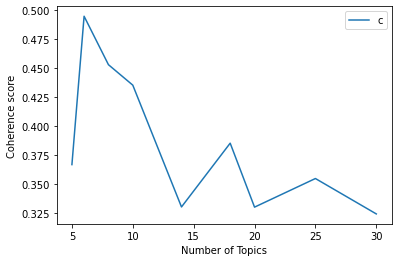

In [ ]:
coh_value_zip_tfidf = plot_coherence_graph(num_topics_list,list(coh_value_dict_tfidf.values()))
# coh_value_zip_tfidf = plot_coherence_graph(num_topics_list,coh_values)

In [ ]:
coh_value_zip_tfidf

{5: 0.3666185833342644,
 6: 0.49498792408968306,
 8: 0.45307751990987344,
 10: 0.4353629723871088,
 14: 0.3299767215332762,
 18: 0.385166317198166,
 20: 0.32982020290121916,
 25: 0.35458250352062465,
 30: 0.3239542821110309}

In [ ]:
max_coh_num_topics_tfidf = max(coh_value_zip_tfidf, key=coh_value_zip_tfidf.get)
max_coh_num_model_tfidf = max(coh_value_dict_tfidf, key=coh_value_dict_tfidf.get)
# coh_val = [v for k,v in coh_value_zip_tfidf.items() if k ==14][0]
# model = [k for k,v in coh_value_dict_tfidf.items() if v == coh_val][0]
topics = max_coh_num_model_tfidf.print_topics(num_topics=max_coh_num_topics_tfidf, num_words=10)
for i in topics:
  print("Topic :", i)

Topic : (0, '0.191*"key" + 0.138*"bike" + 0.137*"people" + 0.135*"chip" + 0.116*"good" + 0.115*"gun" + 0.115*"system" + 0.111*"government" + 0.110*"article" + 0.104*"year"')
Topic : (1, '0.515*"key" + 0.331*"chip" + -0.264*"bike" + 0.231*"encryption" + 0.216*"clipper" + 0.135*"government" + 0.115*"escrow" + 0.114*"phone" + 0.100*"secret" + -0.097*"motorcycle"')
Topic : (2, '-0.312*"drive" + -0.311*"card" + -0.187*"scsi" + 0.185*"gun" + -0.176*"bus" + -0.173*"file" + -0.163*"disk" + -0.152*"graphic" + -0.150*"ide" + -0.149*"controller"')
Topic : (3, '0.594*"bike" + -0.210*"gun" + 0.207*"motorcycle" + -0.168*"player" + 0.167*"dog" + -0.157*"team" + -0.150*"game" + 0.148*"key" + 0.136*"helmet" + -0.123*"baseball"')
Topic : (4, '-0.400*"gun" + 0.290*"player" + 0.287*"team" + 0.274*"game" + 0.208*"jewish" + 0.204*"baseball" + 0.164*"key" + 0.146*"season" + 0.139*"run" + -0.131*"weapon"')
Topic : (5, '0.396*"drive" + 0.249*"scsi" + -0.228*"file" + -0.210*"image" + 0.198*"ide" + -0.196*"graph

In [ ]:
max_coh_num_model_tfidf.get_topics()

array([[ 2.86243591e-02,  1.09995105e-03,  1.35189522e-01, ...,
         2.60166150e-04,  4.06012214e-04,  4.06012214e-04],
       [ 4.70283736e-02,  1.52527691e-03,  3.30970931e-01, ...,
        -1.49622591e-04, -2.45136352e-04, -2.45136352e-04],
       [ 1.92095758e-02,  7.29210226e-04, -1.67625994e-03, ...,
         3.41760457e-04,  2.60102438e-04,  2.60102438e-04],
       [-1.53920223e-03,  1.65538335e-04,  9.15223704e-02, ...,
        -2.55287944e-04, -4.98096809e-04, -4.98096809e-04],
       [-5.84474601e-03,  6.78256009e-04,  8.70864508e-02, ...,
        -6.93276291e-04, -3.74070347e-04, -3.74070347e-04],
       [ 3.35037503e-03,  9.63764023e-05,  7.92903914e-02, ...,
         3.07702840e-04, -4.68362726e-05, -4.68362726e-05]])

In [ ]:
max_coh_num_model_tfidf.show_topics()

[(0,
  '0.191*"key" + 0.138*"bike" + 0.137*"people" + 0.135*"chip" + 0.116*"good" + 0.115*"gun" + 0.115*"system" + 0.111*"government" + 0.110*"article" + 0.104*"year"'),
 (1,
  '0.515*"key" + 0.331*"chip" + -0.264*"bike" + 0.231*"encryption" + 0.216*"clipper" + 0.135*"government" + 0.115*"escrow" + 0.114*"phone" + 0.100*"secret" + -0.097*"motorcycle"'),
 (2,
  '-0.312*"drive" + -0.311*"card" + -0.187*"scsi" + 0.185*"gun" + -0.176*"bus" + -0.173*"file" + -0.163*"disk" + -0.152*"graphic" + -0.150*"ide" + -0.149*"controller"'),
 (3,
  '0.594*"bike" + -0.210*"gun" + 0.207*"motorcycle" + -0.168*"player" + 0.167*"dog" + -0.157*"team" + -0.150*"game" + 0.148*"key" + 0.136*"helmet" + -0.123*"baseball"'),
 (4,
  '-0.400*"gun" + 0.290*"player" + 0.287*"team" + 0.274*"game" + 0.208*"jewish" + 0.204*"baseball" + 0.164*"key" + 0.146*"season" + 0.139*"run" + -0.131*"weapon"'),
 (5,
  '0.396*"drive" + 0.249*"scsi" + -0.228*"file" + -0.210*"image" + 0.198*"ide" + -0.196*"graphic" + 0.177*"gun" + 0.172

In [ ]:
def find_topword(model,n = 10):
  top_word_list = []
  for i in model.show_topics():
    k = i[1]
    top_word_list.append(' '.join(re.findall('"([^"]*)"', k)))
  return top_word_list

In [ ]:
tp_word_list = find_topword(max_coh_num_model_tfidf)
print(len(tp_word_list))
draw_word_cloud(tp_word_list,"TfIDF_LSA_k6")

In [ ]:
np.array(max_coh_num_model_tfidf.__getitem__(doc_term_matrix)).shape

(5672,)